In [1]:
# Start loading libraries

#! pip install yfinance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#! pip install pmdarima
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.model_selection import SlidingWindowForecastCV

import scipy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import arch
import math
import statistics
#from matplotlib.ticker import NullFormatter
#import yfinance as yf
#import warnings; warnings.simplefilter('ignore')
#%matplotlib inline

In [2]:
xls_file = pd.ExcelFile("Data_monthly_final.xlsx") # Read Excel
df1=xls_file.parse("NatGas") # Read the first sheet (Portfolio holdings)

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
df1 = df1.set_index(['Timestamp']) # use first column as index

#df1.to_excel("values.xlsx")  #print to excel



c:\Users\tatuh\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='Timestamp'>

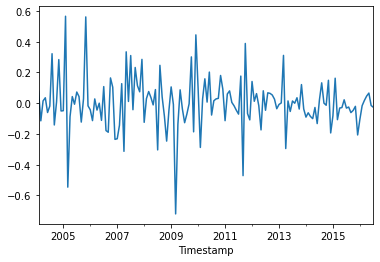

In [3]:
og = df1["TRNLTTFD1 USD"]
spot = df1["TRNLTTFD1 USD"]
spot = np.log(spot)
spot = spot.loc['2004-01-31':'2022-11-30'].diff().dropna()
spot_train = spot.loc[:'2016-07-31']
spot_train.plot()

In [4]:
### original series

spotog = og.loc['2004-01-31':'2022-11-30'].dropna()
trainog, testog = model_selection.train_test_split(spotog, train_size=((spot_train.shape[0])+1))

In [5]:
### realized vol ###

diff_series = og.loc['2004-01-31':'2022-11-30'].diff().dropna()
traindiff, testdiff = model_selection.train_test_split(diff_series, train_size=((spot_train.shape[0])))
realized_vol = testdiff**2
realized_vol


Timestamp
2016-08-31        4.108932
2016-09-30        4.163738
2016-10-31       19.305443
2016-11-30        0.077240
2016-12-31        2.245427
                  ...     
2022-07-31     1518.053029
2022-08-31     1346.028422
2022-09-30     5242.449271
2022-10-31    17449.489275
2022-11-30    13575.131198
Name: TRNLTTFD1 USD, Length: 76, dtype: float64

In [6]:
# Load the data and split it into separate pieces
#data = np.array(spot.dropna())**2
data = np.array(spot.dropna())
train, test = model_selection.train_test_split(data, train_size=(spot_train.shape[0]))
#train, test = model_selection.train_test_split(data, train_size=(spot.shape[0]-1))

In [7]:
garch = arch.arch_model(train,mean='Zero', vol='GARCH', p=1, q=1, rescale=False)
#garch = arch.arch_model(train, vol='GARCH', p=1, q=1)
results = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 90767.62919423934
Iteration:      2,   Func. Count:     12,   Neg. LLF: -15.228588629185559
Iteration:      3,   Func. Count:     17,   Neg. LLF: -50.4922553306824
Iteration:      4,   Func. Count:     22,   Neg. LLF: -50.4922553306824
Iteration:      5,   Func. Count:     27,   Neg. LLF: 831660.5819738262
Iteration:      6,   Func. Count:     34,   Neg. LLF: -44.92344411703441
Iteration:      7,   Func. Count:     39,   Neg. LLF: -50.4922553306824
Iteration:      8,   Func. Count:     44,   Neg. LLF: 29606.982503333275
Iteration:      9,   Func. Count:     51,   Neg. LLF: -56.317241670466494
Iteration:     10,   Func. Count:     56,   Neg. LLF: -50.4922553306824
Iteration:     11,   Func. Count:     61,   Neg. LLF: 47772.67893674657
Iteration:     12,   Func. Count:     68,   Neg. LLF: -60.1470787664781
Iteration:     13,   Func. Count:     72,   Neg. LLF: -59.40949804841746
Iteration:     14,   Func. Count:     77,   Neg. LLF: 209

In [8]:
print(results.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.007
Vol Model:                      GARCH   Log-Likelihood:                61.1271
Distribution:                  Normal   AIC:                          -116.254
Method:            Maximum Likelihood   BIC:                          -107.222
                                        No. Observations:                  150
Date:                Mon, Nov 06 2023   Df Residuals:                      150
Time:                        20:19:28   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.3327e-05  1.013e-03  1.315e-02      0.990 

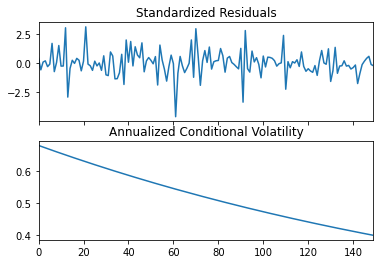

In [9]:
# Plot the standardized residuals
fig = results.plot(annualize='M')
#fig = results.plot()
plt.show()

In [10]:
yhat = results.forecast(horizon=1)
#np.exp(yhat.variance.values)
#math.sqrt(yhat.variance.values.flatten())
#math.sqrt(yhat.variance.values.flatten()[0])
#np.exp(yhat.variance.values.flatten()[0])
yhat.variance.values.flatten()[0]

0.013111592778566964

In [11]:
# Generate statistics and diagnostic plots

#a= results.conditional_volatility
#plt.plot(a)

In [12]:
#### One-step-ahead predictions of volatility ###

predicted_returns = []

for i in range(len(test)):
    insample_data = data[i:-(len(test)-i)]
    
    garch = arch.arch_model(insample_data,mean='Zero', vol='GARCH', p=1, q=1, rescale=False)
    #garch = arch.arch_model(train, vol='GARCH', p=1, q=1)
    results = garch.fit(disp='off')

    yhat = results.forecast(horizon=1)
    log_std = math.sqrt(yhat.variance.values.flatten()[0])

    const_std = np.exp(log_std)
    predicted_returns.append(const_std)


test_shift3 = list(testog)
test_shift3.insert(0, trainog[-1])
test_shift3.pop()

predicted_std_price = list((test_shift3 * np.array(predicted_returns)) - test_shift3)

predicted_vol = pd.DataFrame(predicted_std_price)**2
predicted_std_price


[1.8362087945697692,
 1.5296918822137204,
 1.7375862448666286,
 2.2873274040029727,
 2.2265343514587492,
 2.718524090199182,
 2.416297008411483,
 2.0163662855201103,
 1.782152909694851,
 1.916484702623265,
 1.809661877119602,
 1.7785381009761139,
 1.741855543690349,
 2.5228489887239576,
 2.346126980204758,
 2.437682792233815,
 2.843388493893382,
 2.577477079171164,
 2.3741481257748056,
 9.606800400011764,
 10.18963233961654,
 4.7775038575517,
 4.613616597983732,
 4.427968889235782,
 4.507878078733974,
 5.63349372278741,
 5.519999072143968,
 5.048401966259487,
 4.825439518717992,
 4.4443327434922,
 4.050452989567116,
 3.7017486427445796,
 3.2410149804365105,
 2.825342233903797,
 2.6489201812894656,
 1.9385526615230297,
 1.989508914487546,
 1.819955785600813,
 1.6163608012745065,
 2.196332740126552,
 4.495078090972246,
 2.845342907299786,
 2.0851836101659345,
 1.819586848349882,
 1.6918046704353387,
 1.307409466648207,
 1.158999193091967,
 1.988379547415315,
 1.0735156088073046,
 5.46791

In [13]:
def smape_kun(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))*100

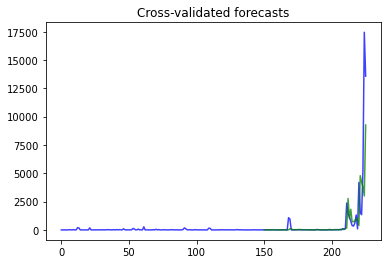

In [14]:
exp_predictions = np.array(predicted_vol)
exp_spot= diff_series**2
exp_test = np.array(realized_vol)
exp_train = traindiff**2

#exp_predictions = np.sqrt(exp_predictions)
#exp_spot= np.sqrt(exp_spot)
#exp_test = np.sqrt(exp_test)
#exp_train = np.sqrt(exp_train)

x_axis = np.arange(exp_spot.shape[0])
n_test = exp_predictions.shape[0]

plt.plot(x_axis, exp_spot, alpha=0.75, c='b')
plt.plot(x_axis[-n_test:], exp_predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Cross-validated forecasts")
plt.show()

In [15]:
error = mean_squared_error(exp_test, exp_predictions)
print('Mean Squared Error: %.3f' % error)
error2 = mean_absolute_error(exp_test, exp_predictions)
print('Mean Absolute Error: %.3f' % error2)
error3 = mean_absolute_percentage_error(exp_test, exp_predictions)
print('Mean Absolute Percentage Error: %.3f' % (error3*100))
error4 = smape_kun(exp_test, exp_predictions)
print('Symmetric Mean Absolute Percentage Error: %.3f' % error4)

Mean Squared Error: 3598689.008
Mean Absolute Error: 520.102
Mean Absolute Percentage Error: 4057.425
Symmetric Mean Absolute Percentage Error: 142.880


In [16]:
### same with built-in function ###

#predictions22 = model_selection.cross_val_score(
#    ar, spot, scoring='mean_absolute_error', cv=cv, verbose=0)
#np.average(predictions22)

In [17]:
#### MASE ###

abs_errors = abs(exp_predictions - exp_test)
mae_naive_list = []

for x in range(len(exp_test)):
    insample_data = exp_spot[x:-(len(exp_test)-x)]
    mae_insample = np.mean(abs(insample_data.diff().dropna()))
    mae_naive_list.append(mae_insample)

mase = np.mean(abs_errors / mae_naive_list)

print('Mean Absolute Scaled Error: %.3f' % mase)

Mean Absolute Scaled Error: 20.842


In [18]:
### Merton test ###

test_app = list(exp_test)
test_app.insert(0, exp_train[-1]) ## append last of train data
dir = np.array(np.sign(pd.DataFrame(test_app).diff().dropna()))

pred_app = list(exp_predictions)

test_shift = list(exp_test)
test_shift.insert(0, exp_train[-1])
test_shift.pop()

dir_pred = np.array(np.sign([a - b for a, b in zip(pred_app,test_shift)]))

q_minus = 0
q_plus = 0
pred_minus = 0
pred_plus = 0

for t in range(len(dir)):
    if dir[t] == 1:
        q_plus += 1
        if dir_pred[t] == 1:
            pred_plus += 1
    if dir[t] == -1:
        q_minus += 1
        if dir_pred[t] == -1:
            pred_minus += 1

print('Merton test: %.3f' % ((pred_plus / q_plus) + (pred_minus / q_minus)))

Merton test: 1.326
